# 2. U-Net Model
Following [this](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) submission notebook from Kaggle.

Mostly using code from the above notebook, but we rewrote the model in tensorflow2 in order to understand the architechure and simplified some components

## 1. Binary Classifier

In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise, BatchNormalization, concatenate, Cropping2D, ZeroPadding2D, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from skimage.io import imread
from sklearn.model_selection import train_test_split

from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import gc
import pickle
import datetime

gc.enable()

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

print(tf.__version__)

2.1.0


In [23]:
# read the mask data provided by kaggle
seg = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(seg.shape[0], 'masks found')
print(seg['ImageId'].value_counts().shape[0], 'unique images found')
seg.sample()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
124694,89ada64c1.jpg,NaN


In [24]:
# identify images that have a mask (ship identification)
from util import agg_ship_count
train_df = agg_ship_count(pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')), train_image_dir)
train_df.sample(10)

,ImageId,ship_count,has_ship,class
109352,91531ffbe.jpg,0,0,no_ship
12232,10306ca2a.jpg,1,1,ship
14634,1360a8bc7.jpg,0,0,no_ship
38715,33955aab0.jpg,0,0,no_ship
174159,e79d07e2a.jpg,0,0,no_ship
124519,a5983008b.jpg,0,0,no_ship
162116,d799acee3.jpg,0,0,no_ship
32361,2af99f8f2.jpg,0,0,no_ship
116370,9aaeb0c67.jpg,0,0,no_ship
117213,9bccca4a6.jpg,2,1,ship


In [53]:
class UNetParams():
    def __init__(self):
        self.batch_size = 4
        self.edge_crop = 16
        self.num_epochs= 1000
        self.gaussian_noise = 0.1
        self.img_scaling = (3, 3)
        self.max_train_steps = 1000
        self.validation_set_size = 1000
        
unet_params = UNetParams()

In [100]:
# Get the masks from kaggle file
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head(5)

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Check Decoding->Encoding RLE_0: 15 -> RLE_1: 5


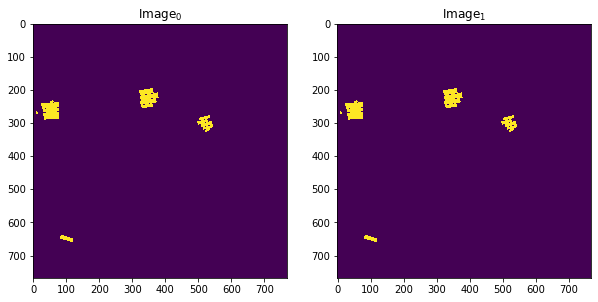

In [55]:
# Plot a mask to test the helper methods
# Image is hard coded to a image with max number of ships (15)
from util import masks_as_image
from util import multi_rle_encode
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="11f3bae66.jpg"')['EncodedPixels'] # 15 ships in the image
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
112230,953c2989c.jpg,0,0.0,[0.0],118.257812
169246,e11d959b5.jpg,0,0.0,[0.0],133.747070
16071,1560dd978.jpg,2,1.0,[1.0],142.263672
75311,6430b2d82.jpg,0,0.0,[0.0],128.604492
155120,ce3db5253.jpg,0,0.0,[0.0],125.561523


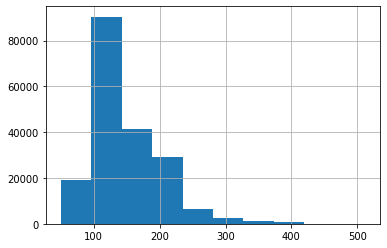

In [56]:
# group images by number of ships
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# Remove images with < 50kb, the could be corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024 if os.path.exists(os.path.join(train_image_dir, c_img_id)) else 0.0)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [57]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


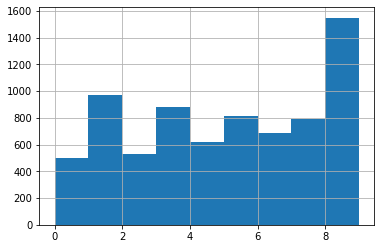

In [58]:
# under sample empty images
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [59]:
from util import make_image_gen
train_gen = make_image_gen(balanced_train_df, unet_params.batch_size, unet_params.img_scaling, train_image_dir)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 256, 256, 3) 0.0 1.0
y (4, 256, 256, 1) 0 1


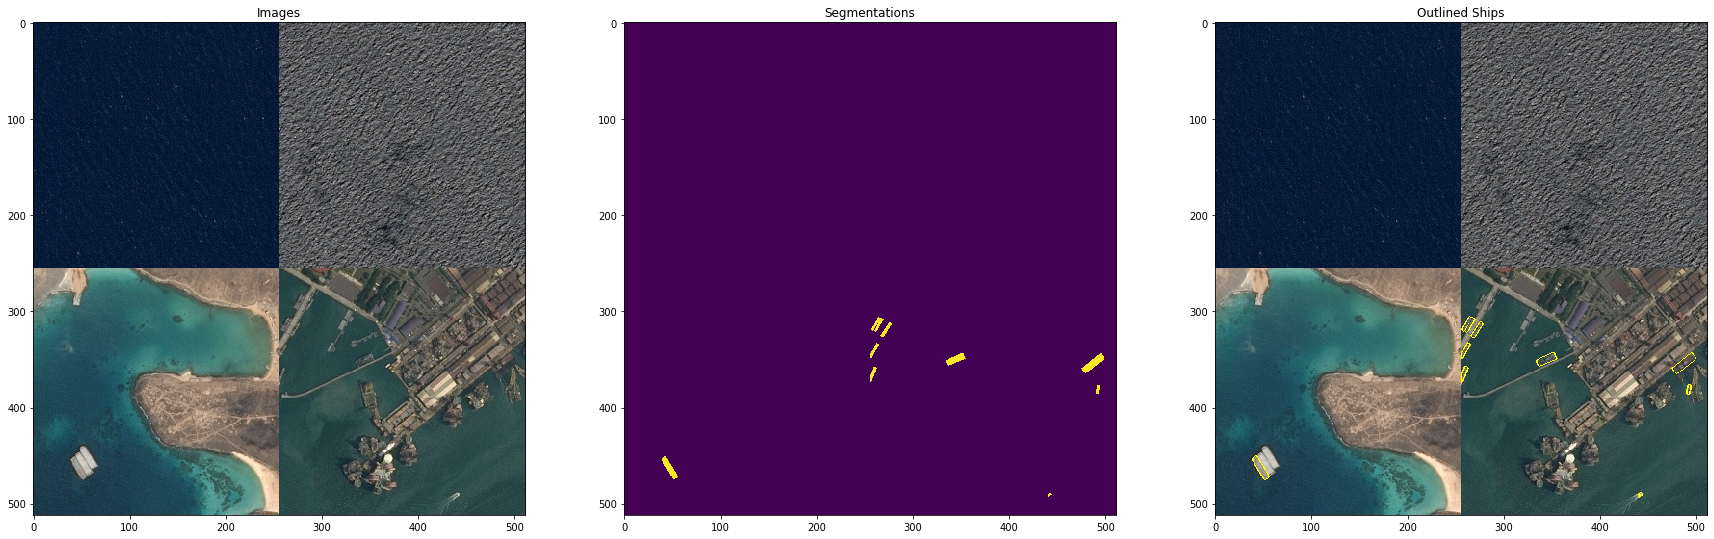

In [60]:
# plot the batching with masks
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('images/overview.png')

In [61]:
valid_x, valid_y = next(make_image_gen(valid_df, unet_params.validation_set_size, unet_params.img_scaling, train_image_dir))
print(valid_x.shape, valid_y.shape)

(1000, 256, 256, 3) (1000, 256, 256, 1)


In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
dg_args = dict(
    featurewise_center = False, 
    samplewise_center = False,
    rotation_range = 15, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],  
    horizontal_flip = True, 
    vertical_flip = True,
    fill_mode = 'reflect',
    data_format = 'channels_last'
)
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

x (4, 256, 256, 3) float32 0.0 0.9981087
y (4, 256, 256, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

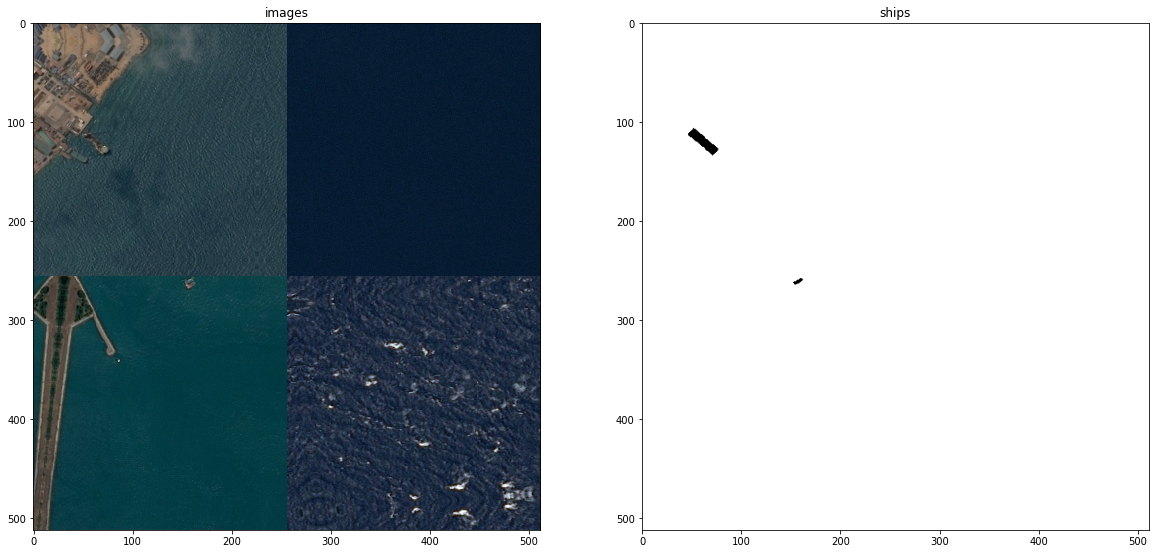

In [63]:
from util import create_aug_gen
cur_gen = create_aug_gen(train_gen, image_gen, label_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [64]:
# garbarge collect before building the model
gc.collect()
K.clear_session()

In [69]:
# Build the U-Net Model

input_img = Input(t_x.shape[1:], name = 'RGB_Input')
input_layer = GaussianNoise(unet_params.gaussian_noise)(input_img)
input_layer = BatchNormalization()(input_layer)

from util import conv_down
from util import conv_up
from util import pool

d1 = conv_down(8, input_img, name='d1')
dp1 = pool(d1, name='d1')
d2 = conv_down(16, dp1, name='d2')
dp2 = pool(d2, name='d2')
d3 = conv_down(32, dp2, name='d3')
dp3 = pool(d3, name='d3')
d4 = conv_down(64, dp3, name='d4')
dp4 = pool(d4, name='d4')
b = conv_down(128, dp4, name='b')
u1 = conv_up(64, b, d4, name='u1')
u2 = conv_up(32, u1, d3, name='u2')
u3 = conv_up(16, u2, d2, name='u3')
u4 = conv_up(8, u3, d1, name='u4')

out = Conv2D(1, (1, 1), activation='sigmoid', name='out_conv1')(u4)
out = Cropping2D((unet_params.edge_crop, unet_params.edge_crop), name='out_crop')(out)
out = ZeroPadding2D((unet_params.edge_crop, unet_params.edge_crop), name='out_pad')(out)

unet = models.Model(inputs=[input_img], outputs=[out], name="UNet")
unet.summary()

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
d1_conv1 (Conv2D)               (None, 256, 256, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
d1_conv2 (Conv2D)               (None, 256, 256, 8)  584         d1_conv1[0][0]                   
__________________________________________________________________________________________________
d1_pool (MaxPooling2D)          (None, 128, 128, 8)  0           d1_conv2[0][0]                   
_______________________________________________________________________________________________

In [70]:
# Loss and metrics
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from util import dice_coef

unet.compile(optimizer=Adam(1e-4), loss=binary_crossentropy, metrics=[dice_coef])

In [72]:
# model callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
model_ts = str(datetime.datetime.now()).replace(' ', '_')
weight_path="models/{}_weights_{}.best.hdf5".format('unet', model_ts)

checkpoint = ModelCheckpoint(
    weight_path, 
    monitor='val_dice_coef', 
    verbose=1, 
    save_best_only=True, 
    mode='max', 
    save_weights_only = True
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_dice_coef', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='max',  
    cooldown=2, 
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_dice_coef", 
    mode="max", 
    patience=15
)

tensorboard = TensorBoard(
    log_dir='summaries', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=False,
    update_freq='epoch', 
    profile_batch=2, 
    embeddings_freq=0,
    embeddings_metadata=None
)

callbacks = [checkpoint, reduceLROnPlat, early, tensorboard]

In [73]:
step_count = min(unet_params.max_train_steps, train_df.shape[0]//unet_params.batch_size)
print(unet_params.img_scaling)
aug_gen = create_aug_gen(
    make_image_gen(train_df,unet_params.batch_size, unet_params.img_scaling, train_image_dir), 
    image_gen, 
    label_gen
)

loss_history = [
    unet.fit(
        aug_gen, 
        steps_per_epoch=step_count, 
        epochs=unet_params.num_epochs, 
        validation_data=(valid_x, valid_y),
        callbacks=callbacks
    )
]

(3, 3)
  ...
    to  
  ['...']
Train for 1000 steps, validate on 1000 samples
Epoch 1/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.0352 - dice_coef: 0.7563
Epoch 00001: val_dice_coef improved from -inf to 0.77450, saving model to models/unet_weights_2020-03-11_20:45:35.784401.best.hdf5
1000/1000 [==============================] - 83s 83ms/step - loss: 0.0351 - dice_coef: 0.7563 - val_loss: 0.0236 - val_dice_coef: 0.7745
Epoch 2/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.0168 - dice_coef: 0.8027
Epoch 00002: val_dice_coef did not improve from 0.77450
1000/1000 [==============================] - 83s 83ms/step - loss: 0.0168 - dice_coef: 0.8024 - val_loss: 0.0236 - val_dice_coef: 0.7745
Epoch 3/1000
 999/1000 [============================>.] - ETA: 0s - loss: 0.0158 - dice_coef: 0.8013
Epoch 00003: val_dice_coef did not improve from 0.77450
1000/1000 [==============================] - 80s 80ms/step - loss: 0.0158 - dice_coef: 0.8015 - val_l

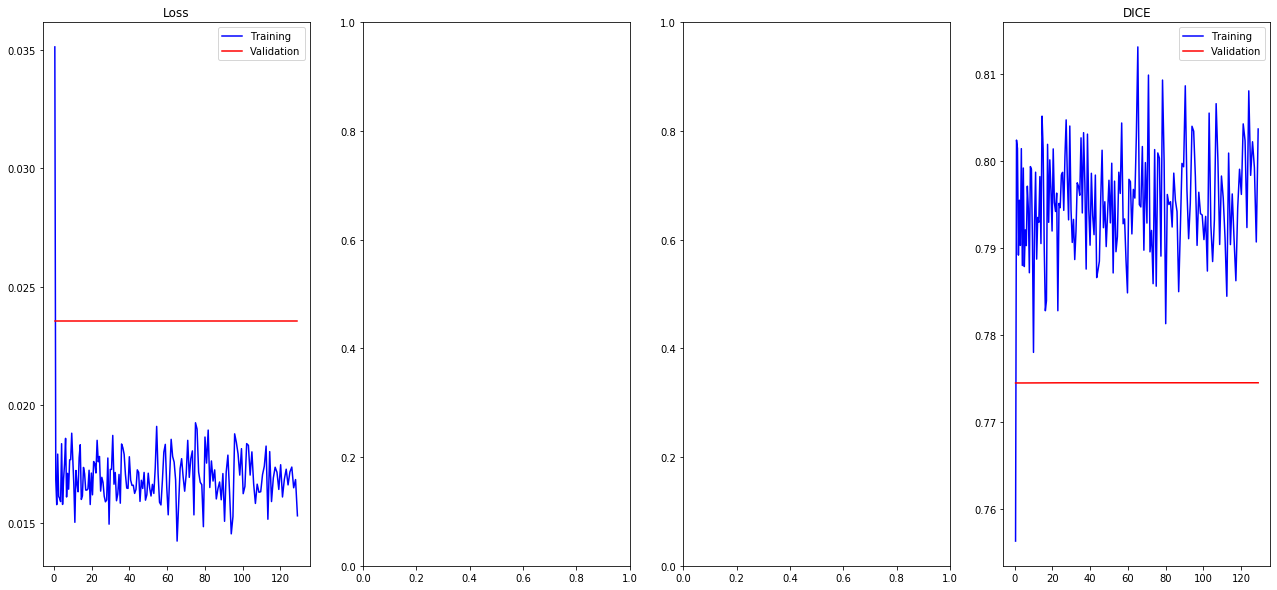

In [74]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')
    
    fig.savefig('images/unet_history_{}.png'.format(model_ts))
show_loss(loss_history)

In [77]:
# save model
unet.load_weights(weight_path)
unet.save('models/unet_model_{}.h5'.format(model_ts))

if unet_params.img_scaling is not None:
    fullres_model = models.Sequential()
    fullres_model.add(AvgPool2D(unet_params.img_scaling, input_shape = (None, None, 3)))
    fullres_model.add(unet)
    fullres_model.add(UpSampling2D(unet_params.img_scaling))
else:
    fullres_model = unet

fullres_model.save('models/unet_fullres_{}.h5'.format(model_ts))

../data/test_v2/63d274848.jpg


TypeError: Invalid shape (768, 768, 1) for image data

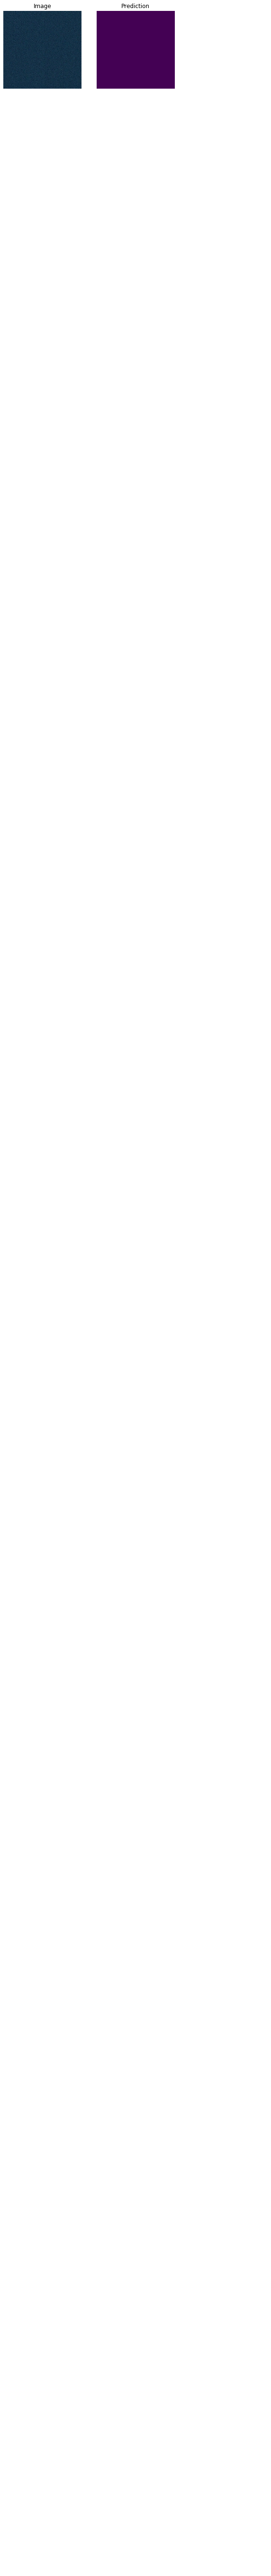

In [103]:
# Predict
fig, m_axs = plt.subplots(20, 3, figsize = (10, 100))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), c_img_name in zip(m_axs, os.listdir(test_image_dir)[140:]):
    c_path = os.path.join(test_image_dir, c_img_name)
    print(c_path)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = fullres_model.predict(first_img)
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
    ground_truth = masks_as_image(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax3.imshow(ground_truth)
    ax3.set_title('Ground Truth')

fig.savefig('images/pred_{}.png'.format(model_ts))